# Домашнее задание №4

## Задача №0 (3)
Дорешайте задачу про риды и BWT из файла practice4.ipynb. В ответе помимо кода укажите количество ридов первой, второй и третьей категории, а также вкратце опишите ход решения.


Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

## Задача №1 (1)
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [1]:
from collections import Counter
from Bio import SeqIO


# Read fasta files
def read_fasta(file_path):
    return ''.join(str(record.seq) for record in SeqIO.parse(file_path, "fasta"))

# Calculate nucleotide frequencies
def nucleotide_freq(seq):
    counts = Counter(seq)
    total = len(seq)
    return {nuc: counts[nuc]/total for nuc in 'ACGT'}

# Calculate dinucleotide frequencies
def dinucleotide_freq(seq):
    dinucs = [seq[i:i+2] for i in range(len(seq)-1)]
    counts = Counter(dinucs)
    total = len(dinucs)
    freqs = {}
    for n1 in 'ACGT':
        for n2 in 'ACGT':
            freqs[n1+n2] = counts[n1+n2]/total
    return freqs

# Read sequences
islands = read_fasta('data/islands.fasta')
non_islands = read_fasta('data/nonIslands.fasta')

# Calculate frequencies
island_nuc = nucleotide_freq(islands)
non_island_nuc = nucleotide_freq(non_islands)
island_dinuc = dinucleotide_freq(islands)
non_island_dinuc = dinucleotide_freq(non_islands)

# Print results
print("Nucleotide frequencies in CpG islands:")
for nuc in 'ACGT':
    print(f"{nuc}: {island_nuc[nuc]:.3f}")

print("\nNucleotide frequencies outside CpG islands:")
for nuc in 'ACGT':
    print(f"{nuc}: {non_island_nuc[nuc]:.3f}")

print("\nDinucleotide frequencies in CpG islands:")
print("    A     C     G     T")
for n1 in 'ACGT':
    print(f"{n1} ", end="")
    for n2 in 'ACGT':
        print(f"{island_dinuc[n1+n2]:.3f} ", end="")
    print()

print("\nDinucleotide frequencies outside CpG islands:")
print("    A     C     G     T")
for n1 in 'ACGT':
    print(f"{n1} ", end="")
    for n2 in 'ACGT':
        print(f"{non_island_dinuc[n1+n2]:.3f} ", end="")
    print()

# CG frequency analysis
print(f"\nCG frequency in islands: {island_dinuc['CG']:.4f}")
print(f"CG frequency outside islands: {non_island_dinuc['CG']:.4f}")
print(f"Ratio (islands/outside): {island_dinuc['CG']/non_island_dinuc['CG']:.2f}")

Nucleotide frequencies in CpG islands:
A: 0.202
C: 0.296
G: 0.298
T: 0.203

Nucleotide frequencies outside CpG islands:
A: 0.289
C: 0.196
G: 0.198
T: 0.316

Dinucleotide frequencies in CpG islands:
    A     C     G     T
A 0.051 0.046 0.072 0.033 
C 0.063 0.103 0.059 0.072 
G 0.060 0.088 0.104 0.047 
T 0.028 0.060 0.064 0.051 

Dinucleotide frequencies outside CpG islands:
    A     C     G     T
A 0.090 0.047 0.070 0.082 
C 0.068 0.050 0.005 0.073 
G 0.060 0.034 0.050 0.054 
T 0.071 0.065 0.073 0.107 

CG frequency in islands: 0.0590
CG frequency outside islands: 0.0053
Ratio (islands/outside): 11.18


**Выводы:**

- Нуклеотидный состав: CpG островки характеризуются повышенным содержанием G (0.298) и C (0.296) по сравнению с остальным геномом (G: 0.198, C: 0.196). Содержание A и T в островках ниже.

- CG динуклеотиды: Частота CG в CpG островках (0.0590) в 11.18 раз выше, чем в остальном геноме (0.0053). Это подтверждает определение CpG островков как регионов с повышенным содержанием CG динуклеотидов.

## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [2]:
import numpy as np
import random


# HMM for CpG islands
class CpGHMM:
    def __init__(self, island_freqs, non_island_freqs):
        self.island_freqs = island_freqs
        self.non_island_freqs = non_island_freqs
        
        # Transition probabilities
        self.transitions = {
            '+': {'+': 0.95, '-': 0.05},
            '-': {'+': 0.005, '-': 0.995}
        }
        
        # Current state
        self.state = '+'  # Start in island state
        self.nucleotides = 'ACGT'
    
    def __iter__(self):
        return self
    
    def __next__(self):
        # Choose nucleotide based on current state
        if self.state == '+':
            probs = [self.island_freqs[nuc] for nuc in self.nucleotides]
        else:
            probs = [self.non_island_freqs[nuc] for nuc in self.nucleotides]
        
        # Generate nucleotide
        nucleotide = np.random.choice(list(self.nucleotides), p=probs)
        
        # Transition to next state
        next_probs = [self.transitions[self.state][s] for s in ['+', '-']]
        next_state = np.random.choice(['+', '-'], p=next_probs)
        
        current_state = self.state
        self.state = next_state
        
        return current_state, nucleotide

# Generate sequences
def generate_sequences(hmm, num_sequences=20, min_length=1000, max_length=100000):
    sequences = []
    states = []
    
    for i in range(num_sequences):
        length = random.randint(min_length, max_length)
        seq = []
        state_seq = []
        
        # Reset HMM state
        hmm.state = '+'
        
        for _ in range(length):
            state, nuc = next(hmm)
            seq.append(nuc)
            state_seq.append(state)
        
        sequences.append(''.join(seq))
        states.append(''.join(state_seq))
    
    return sequences, states

# Create HMM
hmm = CpGHMM(island_nuc, non_island_nuc)

# Generate sequences
sequences, states = generate_sequences(hmm, num_sequences=20)

# Save results
with open('generated_sequences.fasta', 'w') as f:
    for i, seq in enumerate(sequences):
        f.write(f">sequence_{i+1}\n{seq}\n")

with open('generated_states.txt', 'w') as f:
    for i, state_seq in enumerate(states):
        f.write(f">sequence_{i+1}\n{state_seq}\n")

# Print statistics
print(f"Generated {len(sequences)} sequences")
print(f"Sequence lengths: {[len(s) for s in sequences]}")

# Analyze state distributions
all_states = ''.join(states)
state_counts = Counter(all_states)
total_states = len(all_states)
print(f"\nState distribution:")
print(f"+ (islands): {state_counts['+']}/{total_states} ({state_counts['+']/total_states:.3f})")
print(f"- (non-islands): {state_counts['-']}/{total_states} ({state_counts['-']/total_states:.3f})")

# Analyze nucleotide distribution in each state
island_positions = [i for i, s in enumerate(all_states) if s == '+']
non_island_positions = [i for i, s in enumerate(all_states) if s == '-']

all_nucs = ''.join(sequences)
island_nucs = ''.join([all_nucs[i] for i in island_positions])
non_island_nucs = ''.join([all_nucs[i] for i in non_island_positions])

print("\nGenerated nucleotide frequencies in + state:")
if island_nucs:
    gen_island_freqs = nucleotide_freq(island_nucs)
    for nuc in 'ACGT':
        print(f"{nuc}: {gen_island_freqs[nuc]:.3f} (expected: {island_nuc[nuc]:.3f})")

print("\nGenerated nucleotides frequencies in - state:")
if non_island_nucs:
    gen_non_island_freqs = nucleotide_freq(non_island_nucs)
    for nuc in 'ACGT':
        print(f"{nuc}: {gen_non_island_freqs[nuc]:.3f} (expected: {non_island_nuc[nuc]:.3f})")
    

Generated 20 sequences
Sequence lengths: [82508, 15849, 11083, 44758, 55890, 7630, 61363, 14442, 60549, 91208, 29337, 3210, 30991, 10326, 69007, 23200, 99103, 84639, 27087, 52007]

State distribution:
+ (islands): 78694/874187 (0.090)
- (non-islands): 795493/874187 (0.910)

Generated nucleotide frequencies in + state:
A: 0.201 (expected: 0.202)
C: 0.295 (expected: 0.296)
G: 0.301 (expected: 0.298)
T: 0.203 (expected: 0.203)

Generated nucleotides frequencies in - state:
A: 0.289 (expected: 0.289)
C: 0.196 (expected: 0.196)
G: 0.198 (expected: 0.198)
T: 0.317 (expected: 0.316)


## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задаания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG остравков. 

In [5]:
# Viterbi algorithm for CpG island HMM
def viterbi(sequence, island_nuc, non_island_nuc):
    n = len(sequence)
    states = ['+', '-']
    
    # Initialize matrices
    v = np.zeros((2, n))
    path = np.zeros((2, n), dtype=int)
    
    # Initial probabilities (equal for both states)
    v[0][0] = 0.5 * island_nuc[sequence[0]]
    v[1][0] = 0.5 * non_island_nuc[sequence[0]]
    v[:, 0] /= v[:, 0].sum()
    
    # Transition probabilities
    trans = {
        '+': {'+': 0.95, '-': 0.05},
        '-': {'+': 0.005, '-': 0.995}
    }
    
    # Fill the matrices
    for t in range(1, n):
        for s in range(2):
            curr_state = states[s]
            curr_prob = island_nuc[sequence[t]] if s == 0 else non_island_nuc[sequence[t]]
            
            # Find max probability path to current state
            trans_probs = [v[prev_s][t-1] * trans[states[prev_s]][curr_state] for prev_s in range(2)]
            max_prev = np.argmax(trans_probs)
            
            v[s][t] = curr_prob * trans_probs[max_prev]
            path[s][t] = max_prev
        v[:, t] /= v[:, t].sum()
    
    # Backtrack to find the best path
    result = [''] * n
    last_state = np.argmax(v[:, -1])
    result[-1] = states[last_state]
    
    for t in range(n-2, -1, -1):
        last_state = path[last_state][t+1]
        result[t] = states[last_state]
    
    return ''.join(result)

# Read generated sequences and states
sequences = []
true_states = []

with open('generated_sequences.fasta', 'r') as f:
    lines = f.readlines()
    for i in range(0, len(lines), 2):
        if lines[i].startswith('>'):
            sequences.append(lines[i+1].strip())

with open('generated_states.txt', 'r') as f:
    lines = f.readlines()
    for i in range(0, len(lines), 2):
        if lines[i].startswith('>'):
            true_states.append(lines[i+1].strip())

# Apply Viterbi algorithm to each sequence
predicted_states = []
for seq in sequences:
    pred_state = viterbi(seq, island_nuc, non_island_nuc)
    predicted_states.append(pred_state)

# Calculate TP, TN, FP, FN
tp = tn = fp = fn = 0

for true, pred in zip(true_states, predicted_states):
    for t, p in zip(true, pred):
        if t == '+' and p == '+':
            tp += 1
        elif t == '-' and p == '-':
            tn += 1
        elif t == '-' and p == '+':
            fp += 1
        elif t == '+' and p == '-':
            fn += 1

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Viterbi Algorithm Results:")
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")

Viterbi Algorithm Results:
TP: 4041
TN: 794466
FP: 1027
FN: 74653


## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

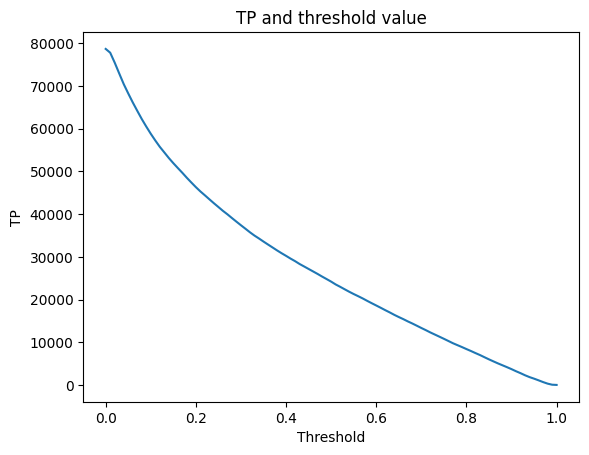

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Forward-backward algorithm for CpG island HMM
def forward_backward(seq, island_nuc, non_island_nuc):
    n = len(seq)
    states = ['+', '-']
    trans = {
        '+': {'+': 0.95, '-': 0.05},
        '-': {'+': 0.005, '-': 0.995}
    }
    f = np.zeros((2, n))
    b = np.zeros((2, n))
    scales = np.zeros(n)
    
    # forward init
    f[0,0] = 0.5 * island_nuc[seq[0]]
    f[1,0] = 0.5 * non_island_nuc[seq[0]]
    scales[0] = f[:,0].sum()
    f[:,0] /= scales[0]
    
    # forward recursion
    for t in range(1, n):
        for s in (0, 1):
            prev = (f[0, t-1] * trans['+'][states[s]] +
                    f[1, t-1] * trans['-'][states[s]])
            emis = island_nuc[seq[t]] if s == 0 else non_island_nuc[seq[t]]
            f[s, t] = prev * emis
        scales[t] = f[:, t].sum()
        f[:, t] /= scales[t]
    
    # backward init
    b[:, n-1] = 1.0
    
    # backward recursion
    for t in range(n-2, -1, -1):
        for s in (0, 1):
            b[s, t] = (
                trans[states[s]]['+'] * island_nuc[seq[t+1]] * b[0, t+1] +
                trans[states[s]]['-'] * non_island_nuc[seq[t+1]] * b[1, t+1]
            )
        b[:, t] /= scales[t+1]
    
    # posterior prob for '+' state
    return f[0] * b[0]

# Threshold analysis: TP vs threshold
thresholds = np.linspace(0, 1, 101)
tp_values = []

for thr in thresholds:
    tp = 0
    for seq, true in zip(sequences, true_states):
        post = forward_backward(seq, island_nuc, non_island_nuc)
        for p, t in zip(post, true):
            if p >= thr and t == '+':
                tp += 1
    tp_values.append(tp)

# Plot TP vs threshold
plt.plot(thresholds, tp_values)
plt.xlabel('Threshold')
plt.ylabel('TP')
plt.title('TP and threshold value')
plt.show()

При низких пороговых значениях (близких к 0) алгоритм «вперёд–назад» находит практически все истинные «+» (TP ≃ 78 694), что сильно больше, чем TP=4041 у Витерби. По мере повышения порогового значения TP монотонно падает, и при значениях выше ≈0.92 TP становится меньше, чем TP=4041 у Витерби.